# House Prices: Advanced Regression Techniques

# Introduction

This kernel addresses the **House Prices: Advanced Regression Techniques** competition.

**Focus:**
- Feature analysis with respect to missing values
- Comparison of different algorithms:
 - **XGBoost**
 - **Gradient Boosting Regressor**
 - **Random Forest Regressor**
 - **LASSO**

The kernel consists of 4 sections:
- **Exploratory Data Analysis**
- **Data Preprocessing**
- **Model Selection**
- **Model Diagnostics**

**Import libraries:**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
import xgboost
import warnings

register_matplotlib_converters()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 2500, 'display.max_rows', 2500, 'display.width', None)

**Read the data:**

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train.name = 'Training set'

test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test.name = 'Test set'

df = pd.concat([train, test]).reset_index(drop=True)
df.name = 'Total database'

**Define functions:**

In [3]:
def correlation(value):
    correlation = df.drop(['Id'], axis=1).apply(lambda x: x.factorize()[0]).corr().abs().unstack().sort_values(kind='quicksort', ascending=False).drop_duplicates(keep='first')
    correlation = correlation.reset_index().rename(columns={0: 'Correlation'})
    correlation = correlation[correlation['level_0'].str.contains(value) |
                              correlation['level_1'].str.contains(value)]
    return correlation[:5]

def countplot(feature, data):
    sns.set(style='darkgrid')
    sns.countplot(data[feature])
    plt.title('{0} ({1})'.format(feature, data.name))
    if len(df.groupby(['Exterior1st']).sum()) > 6:
        plt.xticks(rotation=45, ha='right')
    plt.show()

def catplot(feature, data):
    sns.catplot(x=feature, y='SalePrice', data=data, kind="bar")
    plt.title('Effect of {} on SalePrice'.format(feature)), plt.show()

# 1. Exploratory Data Analysis

## 1.1 Overview

In [4]:
print('Training set:', train.shape)
print('Test set:', test.shape)
print('\nColumns:\n', list(df.columns))

# Data types
print('\nData types:\n{}'.format(df.dtypes))

# Descriptive statistics
df.describe()

Training set: (1460, 81)
Test set: (1459, 80)

Columns:
 ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'Enclose

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


The following column ***MSSubClass*** has a numerical data type. It needs to be converted to categorical columns. Otherwise the model would compare the values which may yield poor results.

In [5]:
for dataset in (train, test, df):
    dataset['MSSubClass'] = dataset['MSSubClass'].astype('str')

## 1.2 Target value *SalePrice*

There are no missing values in the training set for *SalePrice*.

In [6]:
print('Missing values in training set: {}'.format(train['SalePrice'].isna().sum()))

train['SalePrice'].describe()

Missing values in training set: 0


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


The target value looks normally distributed.

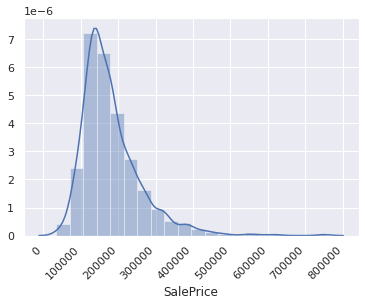

In [7]:
sns.set(style='darkgrid')
sns.distplot(df['SalePrice'], 20),
plt.xticks(rotation=45, ha='right')
plt.show()

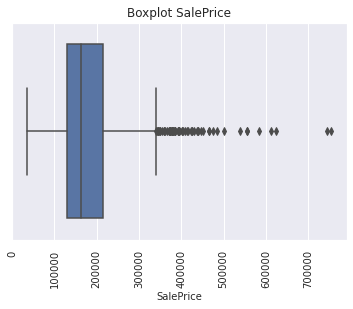

In [8]:
sns.set(style='darkgrid')
sns.boxplot(x=train['SalePrice'])
plt.title('Boxplot SalePrice', fontsize=12), plt.xlabel('SalePrice', fontsize=10), plt.xticks(fontsize=10, rotation=90)
plt.show()

There are some outliers, as the boxplot shows, but the prices of the most expensive houses seem not to be unrealistic (*OverallQual*=10, *CentralAir*=Y, *FullBath*=3, *KitchenQual*=Ex, *TotRmsAbvGrd*=10 etc.).

In [9]:
df[df['SalePrice'] > 700000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455.0,Unf,0.0,989.0,2444.0,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0.0,1.0,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3.0,832.0,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000.0
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000.0


## 1.3 Correlations

The target value *SalePrice* is highly correlated with some of the feature which indicates that the housing prices highly depend on these features. In addition, there are considerable correlations across some of the features.

In [10]:
highest_correlation_target = df.drop(['Id'], axis=1).corr().abs().unstack().sort_values(kind='quicksort', ascending=False)#.drop_duplicates(keep='first')
highest_correlation_target = highest_correlation_target.reset_index().rename(columns={0: 'Correlation'})
highest_correlation_target = highest_correlation_target[highest_correlation_target['level_0'].str.contains('SalePrice') |
                                                        highest_correlation_target['level_1'].str.contains('SalePrice')]
highest_correlation_target = highest_correlation_target[highest_correlation_target['Correlation'] < 1]
highest_correlation_target.drop_duplicates(subset='Correlation')[:10]

,level_0,level_1,Correlation
44,OverallQual,SalePrice,0.790982
46,SalePrice,GrLivArea,0.708624
54,SalePrice,GarageCars,0.640409
60,GarageArea,SalePrice,0.623431
62,SalePrice,TotalBsmtSF,0.613581
68,SalePrice,1stFlrSF,0.605852
88,SalePrice,FullBath,0.560664
98,SalePrice,TotRmsAbvGrd,0.533723
104,YearBuilt,SalePrice,0.522897
108,SalePrice,YearRemodAdd,0.507101


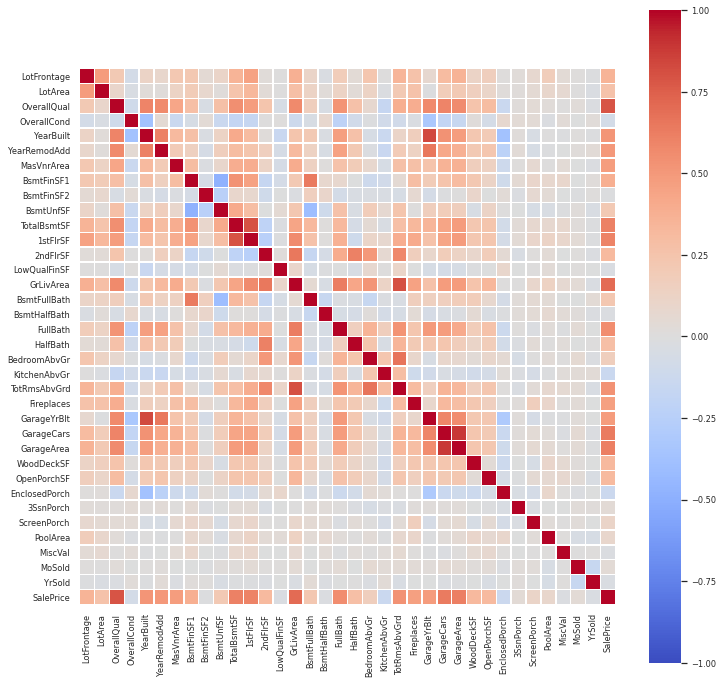

In [11]:
correlation_matrix = df.drop(['Id'], axis=1).corr()#.drop_duplicates(keep='first')

plt.figure(figsize=(12,12))
sns.set(font_scale=0.75)
ax = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, center=0, linewidths=0.5, cmap='coolwarm', square=True, annot=False)

The plots below illustrate the effect of the highest correlating features *OverallQual* and *GrLivArea* on the *SalePrice*. These features are expected to be important for the sales predictions.

**1.3.1 Effect of selected numerical features on *SalePrice***

**a) Feature *OverallQual*:**

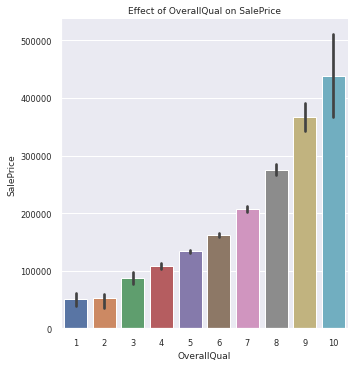

In [12]:
catplot('OverallQual', train)

**b) Feature *GrLivArea*:**

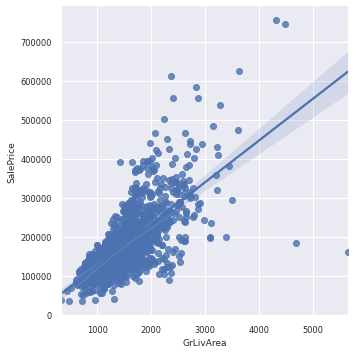

In [13]:
sns.lmplot(x="GrLivArea", y="SalePrice", data=train)
plt.show()

There are 2 outliers in *GrLivArea* with a large *GrLivArea* but a low *SalePrice*. They will be removed.

In [14]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)#.reset_index(drop=False)
df = df.drop(df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)].index)#.reset_index(drop=False)

**c) Features *YearBuilt* & *TotRmsAbvGrd***

The following relational plots captures the effects of *YearBuilt* and *TotRmsAbvGrd* on *SalePrice* in one figure.

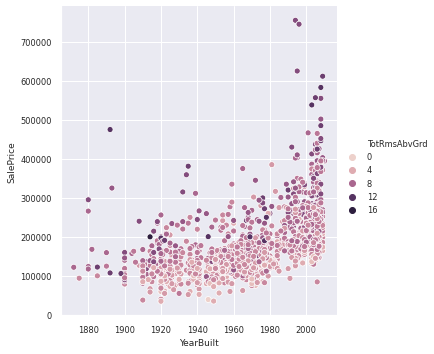

In [15]:
# Relplot
sns.relplot(x='YearBuilt', y='SalePrice', hue='TotRmsAbvGrd', data=train)
plt.show()

**1.3.2 Effect of selected categorical features on *SalePrice***

For most of the categorical features, there are considerable differences in the *SalePrice* among the groups. They are expected to have predictive power for the target as well. This is illustrated based on the features *Neighborhood* and *CentralAir*.

**a) Feature *Neighborhood*:**

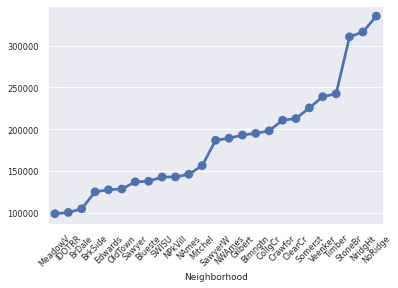

In [16]:
mean_sale_price_neighborhood = train.groupby('Neighborhood')['SalePrice'].mean().sort_values()

sns.pointplot(x =mean_sale_price_neighborhood.index, y =mean_sale_price_neighborhood.values, data=train,
              order=mean_sale_price_neighborhood.index)
plt.xticks(rotation=45)
plt.show()

**b) Feature *CentralAir*:**

*CentralAir* has a positive effect on the target value. This is most relevant when it comes to predicting cheaper houses. 

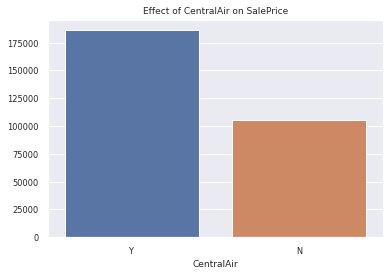

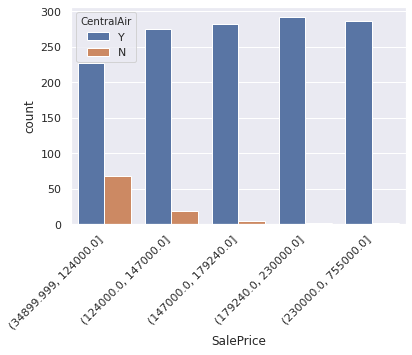

In [17]:
central_air = train.groupby(['CentralAir'])['SalePrice'].mean()
central_air = central_air.sort_index(ascending=False)

plt.figure()
sns.barplot(x=central_air.index, y=central_air.values)
plt.title('Effect of CentralAir on SalePrice')
plt.show()

sns.set(style='darkgrid')
sns.countplot(x=pd.qcut(train['SalePrice'], 5), hue='CentralAir', data=train)
plt.xticks(ha='right', rotation=45)
plt.show()

# 2. Data Preprocessing

## 2.1 Missing values

Columns with missing values will be analyzed and cleaned in detail. The outputs below provide a first overview of missing values.

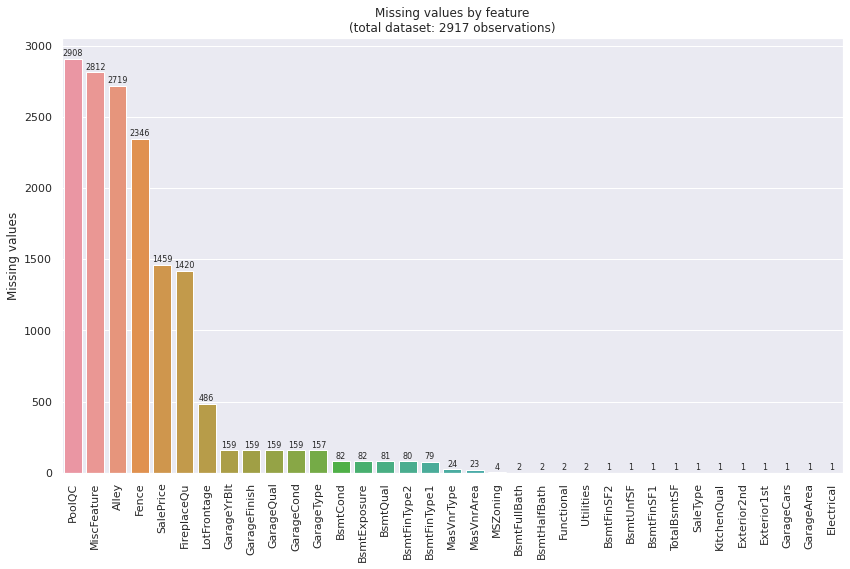

In [18]:
missing = df.isna().sum()
missing = missing[missing.values != 0].sort_values(ascending=False)

plt.figure(figsize=(14,8))
sns.barplot(missing.index, missing.values)
plt.xticks(rotation=90), plt.ylabel('Missing values'), plt.title('Missing values by feature\n(total dataset: {} observations)'.format(len(df)))
for i, v in enumerate(np.around(np.array(missing.values), 4)):
    plt.text(i, v+20, str('%.0f' % v), ha='center', fontsize=8)
plt.show()

- Some columns have lots of missing values others have only a few missing values.
- The columns with missing values might simply be dropped. By doing so, information would get lost though. Thereby, every column with a missing value will be considered in detail.
- In the housing price data, missing values are not completely meaningless. In *PoolQC* and many other columns, a missing value indicates that this item, here a pool, is not avaialable in this house. An additional group 'Not available' has been created.
- This should only be done for categorical features (dtype 'object'). Missing values in numerical columns should be replace with a number.

In [19]:
for dataset in (train, test, df):
    # Categorial features
    for column in ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
        dataset[column] = dataset[column].fillna('Not available')
    
    # Numerical features
    for column in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']:
        dataset[column] = dataset[column].fillna(0)

**2.1.1 Feature *GarageYrBlt***

First of all, the scatterplot reveals an incorrect value in *GarageYrBlt*. According to this, the garage was/will be built in 2207 which does not make sense. This house was built in 2006 and remodeled in 2007. Therefore, 2207 is expected to be a typing error that should mean 2007. The value has been replaced.

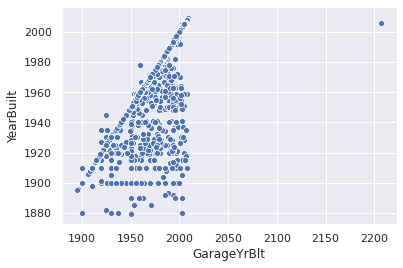

,level_0,level_1,Correlation
9,YearBuilt,GarageYrBlt,0.590849
93,GarageYrBlt,YearRemodAdd,0.263289
106,Foundation,GarageYrBlt,0.251804
129,GarageYrBlt,HeatingQC,0.228037
151,GarageQual,GarageYrBlt,0.213553


In [20]:
sns.set(style='darkgrid')
sns.scatterplot(x='GarageYrBlt', y='YearBuilt', data=df)
plt.show()

correlation('GarageYrBlt')

In [21]:
df.loc[:, ('Id', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd')][df['GarageYrBlt'] == 2207]

,Id,GarageYrBlt,YearBuilt,YearRemodAdd
2592,2593,2207.0,2006,2007


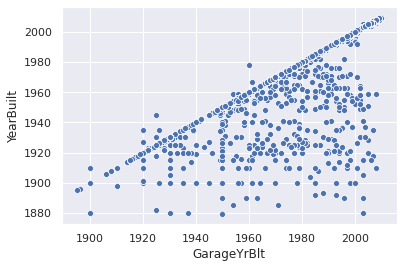

In [22]:
df['GarageYrBlt'] = df['GarageYrBlt'].replace({2207: 2007})

sns.set(style='darkgrid')
sns.scatterplot(x='GarageYrBlt', y='YearBuilt', data=df)
plt.show()

There are 159 missing values in 'GarageYrBlt' which indicate that 159 houses have no garage. By replacing these values with 'Not available', the column would become data type 'object'. This could be critical when it comes to feature scaling and one-hot encoding. NaN values have been replaced with 0. Thereby, the column remains data type 'float' and the feature has no effect on houses without garage.

In [23]:
print('Missing values:', len(df[df['GarageYrBlt'].isna()]))

Missing values: 159


In [24]:
for dataset in (train, test, df):
    dataset['GarageYrBlt'] = dataset['GarageYrBlt'].fillna(0)

**2.1.2 Feature *GarageCars***

There is one house with a missing value in *GarageCars*. It has no garage and thus no car capacity so that the NaN is replaced with 0.

In [25]:
df.loc[:, ('Id', 'GarageCars', 'GarageQual', 'GarageCond')][df['GarageCars'].isna()]

,Id,GarageCars,GarageQual,GarageCond
2576,2577,NaN,Not available,Not available


In [26]:
for dataset in (train, test, df):
    dataset['GarageCars'] = dataset['GarageCars'].fillna(0)

**2.1.3 Feature *GarageArea***

There is one NaN in the numerical column *GarageArea*. The missing value addresses a house without garage. Therefore, the NaN can be replaced with 0.

In [27]:
df.loc[:, ('Id', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond')][df['GarageArea'].isna()]

,Id,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
2576,2577,Not available,0.0,NaN,Not available,Not available


In [28]:
for dataset in (train, test, df):
    dataset['GarageArea'] = dataset['GarageArea'].fillna(0)

**2.1.4 Features *BsmtQual*, *BsmtCond*, *BsmtExposure*, *BsmtFinType1*, *BsmtFinType2***

The missing value overview has shown that houses without basement have not consistently 'Not available' in the 'object' columns addressing the basement (*BsmtQual*, *BsmtCond*, *BsmtExposure*, *BsmtFinType1*, *BsmtFinType2*). See output below.

In [29]:
for feature in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    print('{0}: {1}'.format(feature, len(df[df[feature] == 'Not available'])))

BsmtQual: 81
BsmtCond: 82
BsmtExposure: 82
BsmtFinType1: 79
BsmtFinType2: 80


In [30]:
basement = df
basement['Count'] = basement['BsmtQual'].str.count('Not available') + basement['BsmtCond'].str.count('Not available') + basement['BsmtExposure'].str.count('Not available') + basement['BsmtFinType1'].str.count('Not available') + basement['BsmtFinType2'].str.count('Not available')
basement.loc[:, ('Id', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'TotalBsmtSF')][(basement['Count'] < 5) & (basement['Count'] > 0)]

,Id,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF
332,333,Gd,TA,No,GLQ,Not available,3206.0
948,949,Gd,TA,Not available,Unf,Unf,936.0
1487,1488,Gd,TA,Not available,Unf,Unf,1595.0
2040,2041,Gd,Not available,Mn,GLQ,Rec,1426.0
2185,2186,TA,Not available,No,BLQ,Unf,1127.0
2217,2218,Not available,Fa,No,Unf,Unf,173.0
2218,2219,Not available,TA,No,Unf,Unf,356.0
2348,2349,Gd,TA,Not available,Unf,Unf,725.0
2524,2525,TA,Not available,Av,ALQ,Unf,995.0


It becomes clear that there are incorrect 'Not available' values which need to be cleaned.
The following columns need to be considered in detail:

a) *BsmtQual*

b) *BsmtCond*

c) *BsmtExposure*

d) *BsmtFinType2*

**a) Feature *BsmtQual***

This feature correlates most with *OverallQual*. The two 'Not available' values that should be cleaned might be replaced based on the *OverallQual* values.

In [31]:
correlation('BsmtQual')

,level_0,level_1,Correlation
19,OverallQual,BsmtQual,0.444590
33,Foundation,BsmtQual,0.391232
39,BsmtQual,KitchenQual,0.368511
44,ExterQual,BsmtQual,0.350165
52,BsmtCond,BsmtQual,0.332459


Both houses have an *OverallQual* of 4 while the mean *OverallQual* is round about 6. *BsmtQual* is thus not replaced by 'TA' (='Typical') which is supposed to indicate the default value, but by 'FA' (='Fair') which is one class below 'TA'.

In [32]:
df.loc[2217:2218, ('BsmtQual', 'OverallQual')]

,BsmtQual,OverallQual
2217,Not available,4
2218,Not available,4


In [33]:
print('Mean OverallQual: {}'.format(round(df['OverallQual'].mean(), 2)))

for dataset in (train, test, df):
    for value in (2218, 2219):
        dataset.loc[dataset['Id'] == value, 'BsmtQual'] = 'TA'

Mean OverallQual: 6.09


**b) Feature *BsmtCond***

Results have shown earlier that there is 'Not available' in the *BsmtCond* of three houses, although these houses have a basement. *BsmtCond* correlates most with *BsmtQual*. Since both features have the same values, the missing values in *BsmtCond* are thus replaced by the values for *BsmtQual*.

In [34]:
correlation('BsmtCond')

,level_0,level_1,Correlation
28,BsmtCond,Count,0.402407
53,BsmtQual,BsmtCond,0.330259
55,BsmtCond,Foundation,0.328119
102,BsmtCond,CentralAir,0.262066
120,BsmtFinType1,BsmtCond,0.245323


In [35]:
for dataset in (train, test, df):
    dataset['BsmtCond'] = np.where((dataset['BsmtCond'] == 'Not available') &
                                   (dataset['BsmtQual'] != 'Not available'), dataset['BsmtQual'], dataset['BsmtCond'])
        
df.loc[(2040, 2185, 2524), ('BsmtQual', 'BsmtCond')]

,BsmtQual,BsmtCond
2040,Gd,Gd
2185,TA,TA
2524,TA,TA


**c) Feature *BsmtExposure***

*BsmtExposure* correlates most with *HouseStyle* and the houses with missing values have the style '2Story' or '1Story'.

In [36]:
correlation('BsmtExposure')

,level_0,level_1,Correlation
35,Count,BsmtExposure,0.386808
325,HouseStyle,BsmtExposure,0.154690
377,BsmtCond,BsmtExposure,0.143270
489,BsmtExposure,BsmtFinType2,0.124334
503,2ndFlrSF,BsmtExposure,0.121896


In [37]:
df.loc[(948, 1487, 2348), ('BsmtExposure', 'HouseStyle')]

,BsmtExposure,HouseStyle
948,Not available,2Story
1487,Not available,1Story
2348,Not available,2Story


Most houses with the style '2Story' and '1Story' have no basement exposure. The *BsmtExposure* value for the 3 houses was changed from 'Not available' (since the houses clearly have a basement) to 'No'. 

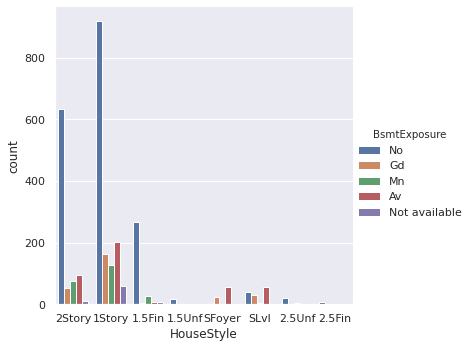

In [38]:
correlation('BsmtExposure')
sns.catplot(x='HouseStyle', hue='BsmtExposure', data=df, kind='count')
plt.show()

In [39]:
for dataset in (train, test, df):
    for value in (949, 1488, 2349):
        dataset.loc[dataset['Id'] == value, 'BsmtExposure'] = 'No'

**d) Feature *BsmtFinType2***

*BsmtFinType2* shows the highest correlation with *BsmtFinSF2*. The house with the incorrect 'Not available' in *BsmtFinType2* has 479.0 type 2 finished square feet in the basement.

In [40]:
correlation('BsmtFinType2')

,level_0,level_1,Correlation
3,BsmtFinSF2,BsmtFinType2,0.745222
121,BsmtFinType1,BsmtFinType2,0.244230
308,BsmtFinType2,Count,0.159720
330,Exterior1st,BsmtFinType2,0.151925
389,Exterior2nd,BsmtFinType2,0.141124


In [41]:
df.loc[[332], ('Id', 'BsmtFinType2', 'BsmtFinSF2')]

,Id,BsmtFinType2,BsmtFinSF2
332,333,Not available,479.0


There are 107 houses with similar BsmtFinSF2 size, as the bar chart below shows.

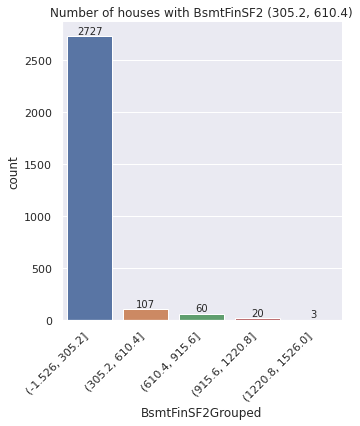

In [42]:
df['BsmtFinSF2Grouped'] = pd.cut(df['BsmtFinSF2'], 5)

sns.catplot(x='BsmtFinSF2Grouped', data=df, kind='count')
plt.xticks(rotation=45, ha='right')
plt.title('Number of houses with BsmtFinSF2 (305.2, 610.4)')
for i, v in enumerate(np.array(df.groupby('BsmtFinSF2Grouped')['BsmtFinType2'].count())):
    plt.text(i, v+20, v, ha='center', fontsize=10) 
plt.show()

From the 6 *BsmtFinType1* groups, 'Rec' which indicates an average rec room is the most common one (see pie chart below). The missing value has been replaced with 'Rec'.

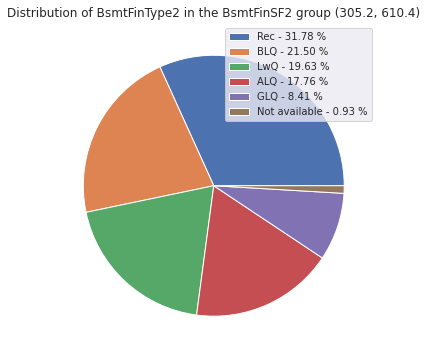

In [43]:
df_new = df[df['BsmtFinSF2Grouped'] == pd.Interval(305.2, 610.4)]

percentage = 100 * df_new['BsmtFinType2'].value_counts() / df_new['BsmtFinType2'].value_counts().sum()
plt.figure(figsize=(10,6))
plt.pie(percentage)
plt.legend(['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(percentage.index, percentage)], loc='best', fontsize=10, frameon=True)
plt.title('Distribution of BsmtFinType2 in the BsmtFinSF2 group (305.2, 610.4)')
plt.show()

for dataset in (train, test, df):
    dataset.loc[dataset['Id'] == 333, 'BsmtFinType2'] = 'Rec'


The final output shows that there are consistently 79 houses without a basement after the basement columns have been cleaned.

In [44]:
for feature in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    print('{0}: {1}'.format(feature, len(df[df[feature] == 'Not available'])))

BsmtQual: 79
BsmtCond: 79
BsmtExposure: 79
BsmtFinType1: 79
BsmtFinType2: 79


**2.1.5 Feature *MSZoning***

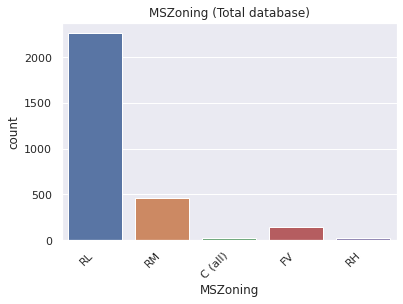

Missing values in MSZoning: 4


,level_0,level_1,Correlation
25,Alley,MSZoning,0.419973
78,BldgType,MSZoning,0.288919
117,MSSubClass,MSZoning,0.248300
321,MSZoning,Fireplaces,0.156939
345,YearRemodAdd,MSZoning,0.149526


In [45]:
df.name = 'Total database'
countplot('MSZoning', df)

print('Missing values in MSZoning: {}'.format(df['MSZoning'].isna().sum()))

correlation('MSZoning')

*MSZoning* correlates most with *Alley*. The houses with missing values in *MSZoning* have no alley.

In [46]:
df.loc[:, ('Id', 'MSZoning', 'Alley')][df['MSZoning'].isna()]

,Id,MSZoning,Alley
1915,1916,NaN,Not available
2216,2217,NaN,Not available
2250,2251,NaN,Not available
2904,2905,NaN,Not available


Most of the houses without alley turned out to have 'RL' in *MSZoning*. The missing values have thus been replaced by 'RL'.

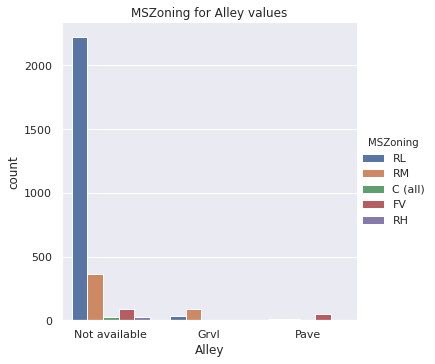

In [47]:
sns.catplot(x='Alley', hue='MSZoning', data=df, kind='count')
plt.title('MSZoning for Alley values')
plt.show()

for dataset in (train, test, df):
    dataset['MSZoning'] = dataset['MSZoning'].fillna('RL')

**2.1.6 Feature *Utilities***

There are 2 missing values in *Utilities*. The column has 2916 observations with 'AllPub' and 1 observation with 'NoSeWa'. The missing value has been replaced by 'AllPub'.

Missing values in Utilities: 2


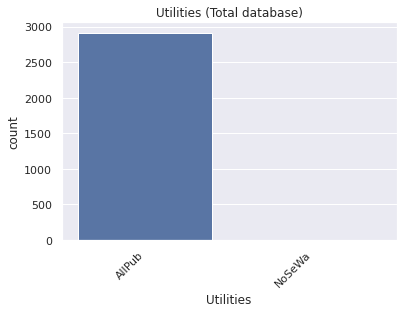

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64


In [48]:
print('Missing values in Utilities: {}'.format(df['Utilities'].isna().sum()))

countplot('Utilities', df)

print(df['Utilities'].value_counts())

for dataset in (train, test, df):
    dataset['Utilities'] = dataset['Utilities'].fillna('AllPub')

**2.1.7 Features *Exterior1st* & *Exterior2nd***

There is 1 missing value in 'Exterior1st' and 'Exterior2nd'.

Missing values in Exterior1st: 1
Missing values in Exterior2nd: 1


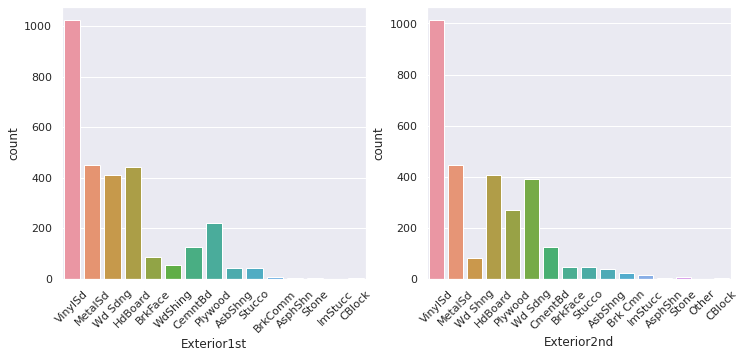

In [49]:
print('Missing values in Exterior1st: {}'.format(df['Exterior1st'].isna().sum()))
print('Missing values in Exterior2nd: {}'.format(df['Exterior2nd'].isna().sum()))

fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.countplot(df['Exterior1st'], ax=ax[0])
sns.countplot(df['Exterior2nd'], ax=ax[1])
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
fig.show()

The features are highly correlated and *Exterior2nd* correlates most with *Foundation*.

In [50]:
correlation('Exterior1st|Exterior2nd')

,level_0,level_1,Correlation
2,Exterior2nd,Exterior1st,0.753198
49,Exterior2nd,Foundation,0.342868
51,Exterior2nd,HeatingQC,0.341376
52,Exterior1st,HeatingQC,0.337594
86,Foundation,Exterior1st,0.284264


The missing value has a *Foundation* of 'PConc' ('Poured Contrete').

In [51]:
df.loc[:, ('Id', 'Exterior1st', 'Exterior2nd', 'Foundation')][df['Exterior1st'].isnull()]

,Id,Exterior1st,Exterior2nd,Foundation
2151,2152,NaN,NaN,PConc


In the group of 'PConc', most houses have Exterior 'VinylSd'. The missing value has thus been replaced with the most common value 'VinylSd'.


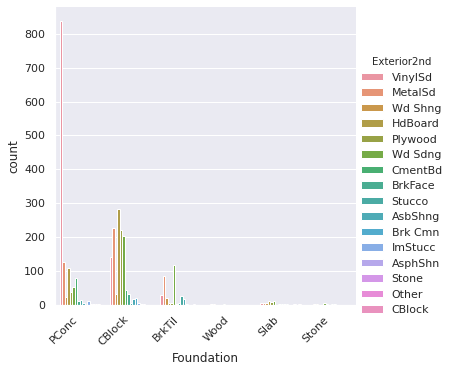

In [52]:
sns.catplot(x='Foundation', data=df, hue='Exterior2nd', kind='count')
plt.xticks(rotation=45, ha='right')
plt.show()

for dataset in (train, test, df):
    dataset['Exterior1st'] = dataset['Exterior1st'].fillna('VinylSd')
    dataset['Exterior2nd'] = dataset['Exterior2nd'].fillna('VinylSd')

**2.1.8 Features *MasVnrType* & *MasVnrArea***

The features *MasVnrType* & *MasVnrArea* indicate the masonry veneer type and area. There are 23 and 24 missing values. The values are not trivial according to the countplot.

Missing values in MasVnrType: 24
Missing values in MasVnrArea: 23


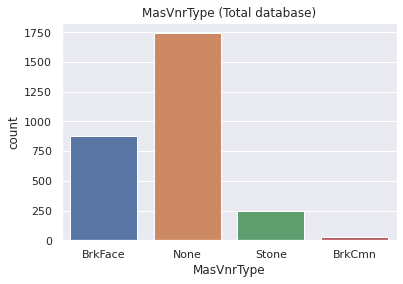

In [53]:
print('Missing values in MasVnrType: {}'.format(df['MasVnrType'].isna().sum()))
print('Missing values in MasVnrArea: {}'.format(df['MasVnrArea'].isna().sum()))

sns.set(style='darkgrid')
sns.countplot(df['MasVnrType'])
plt.title('{0} ({1})'.format('MasVnrType', df.name))
plt.show()

The masonry veneer may depend on *YearBuilt*. The numeric feature *YearBuilt* has been grouped into 10 bins, as the plot shows.

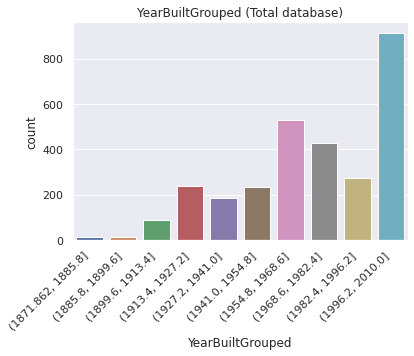

In [54]:
df['YearBuiltGrouped'] = pd.cut(df['YearBuilt'], 10)
countplot('YearBuiltGrouped', df)

Older houses have mostly 'None' value while newer houses have different *MasVnrType*. The missing values only address newer houses so that they cannot be replaced reliably based on *YearBuilt*.

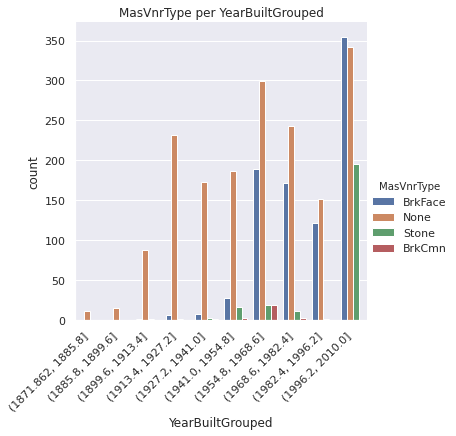

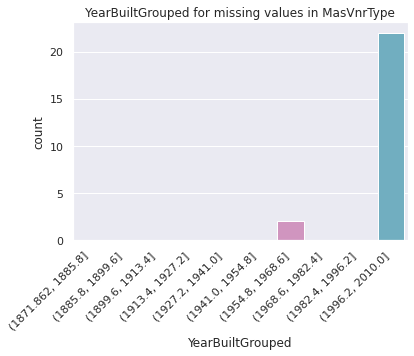

In [55]:
sns.set(style='darkgrid')
sns.catplot(x='YearBuiltGrouped', data=df, hue='MasVnrType', kind='count')
plt.xticks(rotation=45, ha='right')
plt.title('MasVnrType per YearBuiltGrouped')
plt.show()

missing_MasVnrType = df[df["MasVnrType"].isnull()]
sns.set(style='darkgrid')
sns.countplot(missing_MasVnrType['YearBuiltGrouped'])
plt.title('YearBuiltGrouped for missing values in MasVnrType')
plt.xticks(rotation=45, ha='right')
plt.show()

Correlations may yield better insights. *MasVnrArea* has correlates most with *Fireplaces*.

In [56]:
correlation('MasVnrArea')

,level_0,level_1,Correlation
58,MasVnrType,MasVnrArea,0.337552
196,Fireplaces,MasVnrArea,0.204632
201,TotalBsmtSF,MasVnrArea,0.201563
207,MasVnrArea,GarageArea,0.197581
221,LotArea,MasVnrArea,0.193458


Houses with missing values in *MasVnrType* have between 0 and 2 fire places. There is no clear relationship also between *MasVnrType* and *Fireplaces*.

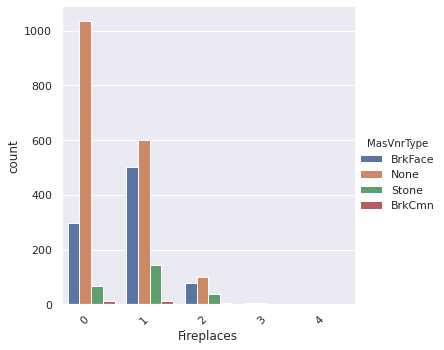

,Id,MasVnrType,Fireplaces
234,235,NaN,2
529,530,NaN,2
650,651,NaN,0
936,937,NaN,0
973,974,NaN,0
977,978,NaN,0
1243,1244,NaN,1
1278,1279,NaN,1
1691,1692,NaN,1
1706,1707,NaN,0


In [57]:
sns.catplot(x='Fireplaces', data=df, hue='MasVnrType', kind='count')
plt.xticks(rotation=45, ha='right')
plt.show()

df.loc[:, ('Id', 'MasVnrType', 'Fireplaces')][df['MasVnrType'].isnull()]

There is no way to reliably replace the NaN values in *MasVnrType* and *MasVnrArea*. Thus, both columns are dropped from the database.

In [58]:
train = train.drop(['MasVnrType', 'MasVnrArea'], axis=1)
test = test.drop(['MasVnrType', 'MasVnrArea'], axis=1)
df = df.drop(['MasVnrType', 'MasVnrArea'], axis=1)

**2.1.9 Feature *LotFrontage***

There are 486 missing values in *LotFrontage*. Due to the large number of missing values the feature might simply be dropped. The feature has been grouped to get better insights into how it is distributed. There are no irregularities in its distribution. *LotFrontage* correlates most with *BldgType*.

Missing values in LotFrontage: 486


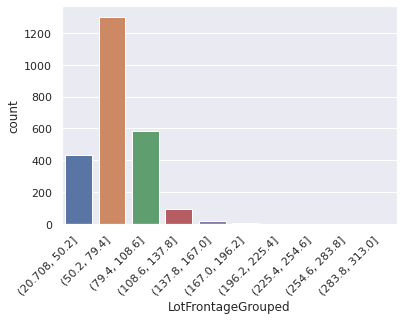

,level_0,level_1,Correlation
0,LotFrontageGrouped,LotFrontageGrouped,1.000000
15,LotFrontage,LotFrontageGrouped,0.507347
99,LotFrontageGrouped,BldgType,0.283859
238,MSSubClass,LotFrontageGrouped,0.187467
265,LotFrontage,LotArea,0.178738


In [59]:
print('Missing values in LotFrontage: {}'.format(df['LotFrontage'].isna().sum()))

df['LotFrontageGrouped'] = pd.cut(df['LotFrontage'], 10)

sns.countplot(df['LotFrontageGrouped'])
plt.xticks(rotation=45, ha='right')
plt.show()

correlation('LotFrontage')

The missing values in *LotFrontage* have different building types. Since *LotFrontage* is a numeric feature, it has been replaced with the mean *LotFrontage* for the respective *BldgType*.

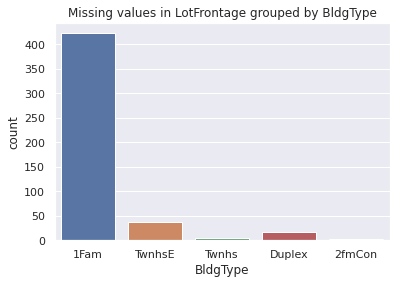

In [60]:
missing_LotFrontage = df.loc[:, ('Id', 'LotFrontage', 'BldgType')][df['LotFrontage'].isna()]
sns.countplot(missing_LotFrontage['BldgType'])
plt.title('Missing values in LotFrontage grouped by BldgType')
plt.show()

for dataset in (train, test, df):
    dataset['LotFrontage'] = dataset['LotFrontage'].fillna(df.groupby('BldgType')['LotFrontage'].transform('mean'))

**2.1.10 Feature *Electrical***

There is only 1 missing value in *Electrical*. The feature shows a considerable correlation with *CentralAir* which indicates whether the house has a central air conditioning.

Missing values in Electrical: 1


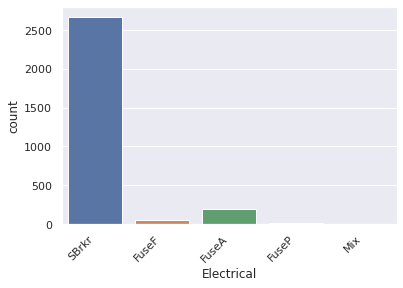

,level_0,level_1,Correlation
74,CentralAir,Electrical,0.311248
120,YearBuiltGrouped,Electrical,0.258981
143,Electrical,Foundation,0.238404
203,Electrical,HeatingQC,0.201407
204,Electrical,GarageCars,0.200720


In [61]:
print('Missing values in Electrical: {}'.format(df['Electrical'].isna().sum()))

sns.countplot(df['Electrical'])
plt.xticks(rotation=45, ha='right')
plt.show()

correlation('Electrical')

The house with a missing value in *Electrical* has a central air conditioning.

In [62]:
df.loc[:, ('Id', 'Electrical', 'CentralAir')][df['Electrical'].isna()]

,Id,Electrical,CentralAir
1379,1380,NaN,Y


Over 94% of  houses with central air conditioning have a 'Standard Circuit Breakers & Romex' electrical sytstem. Therefore, the house with the missing value is expected to have the same electrical system. The missing value has been replaced by 'Sbrkr'.

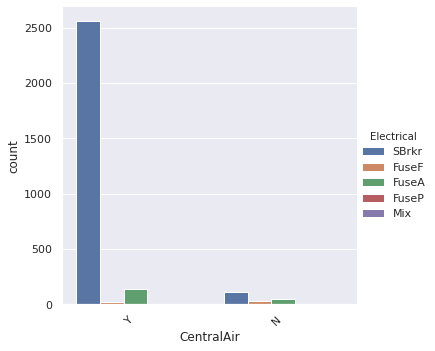

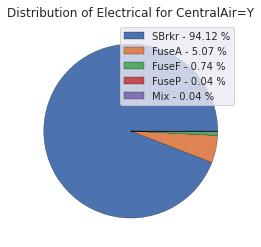

In [63]:
sns.catplot(x='CentralAir', data=df, hue='Electrical', kind='count')
plt.xticks(rotation=45, ha='right')
plt.show()

distribution = df.groupby('CentralAir')['Electrical'].value_counts()[4:]
legend = ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']    
percentage = 100 * distribution.values / distribution.values.sum()

plt.pie(distribution.values / distribution.values.sum(), wedgeprops=dict(edgecolor='black', linewidth=0.25))
plt.legend(['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(legend, percentage)], loc='best', fontsize=10, frameon=True)
plt.title('Distribution of Electrical for CentralAir=Y', fontsize=12)
plt.show()

for dataset in (train, test, df):
    dataset['Electrical'] = dataset['Electrical'].fillna('Sbrkr')

**2.1.11 Features *BsmtFullBath* & *BsmtHalfBath***

There are 2 observations which have a missing value in both *BsmtFullBath* and *BsmtHalfBath*.

In [64]:
print('Missing values in BsmtFullBath: {}'.format(df['BsmtFullBath'].isna().sum()))
print('Missing values in BsmtHalfBath: {}'.format(df['BsmtHalfBath'].isna().sum()))

Missing values in BsmtFullBath: 2
Missing values in BsmtHalfBath: 2


The output below shows that these houses have no basement. Thus, they obviously have 0 full and 0 half bathrooms in the basement. The vales have been replaced with 0.

In [65]:
df.loc[:, ('Id', 'BsmtQual', 'BsmtFullBath', 'BsmtHalfBath')][df['BsmtFullBath'].isna()|df['BsmtHalfBath'].isna()]

,Id,BsmtQual,BsmtFullBath,BsmtHalfBath
2120,2121,Not available,NaN,NaN
2188,2189,Not available,NaN,NaN


In [66]:
for dataset in (train, test, df):
    for feature in ('BsmtFullBath', 'BsmtHalfBath'):
        dataset[feature] = dataset[feature].fillna(0)

**2.1.12 Feature *KitchenQual***

There is only 1 NaN in *KitchenQual*. This house correlates highly with other features indicating the quality of the house.

In [67]:
print('Missing values in KitchenQual: {}'.format(df['KitchenQual'].isna().sum()))

correlation('KitchenQual')

Missing values in KitchenQual: 1


,level_0,level_1,Correlation
14,ExterQual,KitchenQual,0.519045
24,OverallQual,KitchenQual,0.431769
46,BsmtQual,KitchenQual,0.368619
90,KitchenQual,HeatingQC,0.288755
100,GarageCars,KitchenQual,0.283375


The house has average values for the remaining quality features.

In [68]:
df.loc[:, ('KitchenQual','ExterQual', 'BsmtQual', 'OverallQual')][df['KitchenQual'].isna()]

,KitchenQual,ExterQual,BsmtQual,OverallQual
1555,NaN,TA,Gd,5


The feature *ExterQual* which *KitchenQual* correlates most with has the same column values so that missing value can be replaced easily. Missing value after cleaning:

In [69]:
for dataset in (train, test, df):
    dataset['KitchenQual'] = dataset['KitchenQual'].fillna(dataset['ExterQual'])

df.loc[[1555], ('KitchenQual','ExterQual', 'OverallQual')]

,KitchenQual,ExterQual,OverallQual
1555,TA,TA,5


**2.1.13 Feature *Functional***

This feature indicates the home functionality. 'Typ' is assumed unless deductions are warranted. Two houses have no information for its functionality. In fact, 93% of the houses have a typical functionality. The two missing values were replaced by 'Typ'.

Missing values in Functional: 2


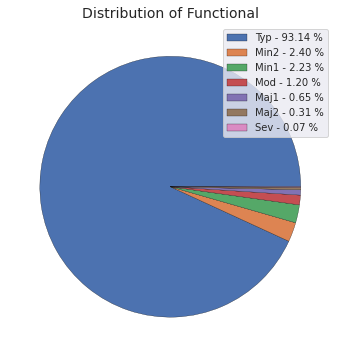

In [70]:
print('Missing values in Functional: {}'.format(df['Functional'].isna().sum()))

plt.figure(figsize=(8, 6))
plt.pie(df['Functional'].value_counts() / df['Functional'].value_counts().sum(),
        wedgeprops=dict(edgecolor='black', linewidth=0.25))
percentage = 100. * df['Functional'].value_counts() / df['Functional'].value_counts().sum()
plt.legend(['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(percentage.index, percentage)],
           loc='best', fontsize=10, frameon=True)
plt.title('Distribution of Functional', fontsize=14)
plt.show()

# Replace NaN with 'Typ'
for dataset in (train, test, df):
    dataset['Functional'] = dataset['Functional'].fillna('Typ')

**2.1.14 Feature *SaleType***

*SaleType* contains different types, such as conventional, cash or loan. There is only 1 missing value in *SaleType*. However, this feature is assumed to have no effect on the price of the house. Indeed, there is no correlation between *SaleType* and *SalePrice*. The feature has thus been dropped from the database.

In [71]:
print('Missing values in SaleType: {}'.format(df['SaleType'].isna().sum()))

df.loc[:, ('SalePrice', 'SaleType')].apply(lambda x: x.factorize()[0]).corr()

train = train.drop('SaleType', axis=1)
test = test.drop('SaleType', axis=1)
df = df.drop('SaleType', axis=1)

Missing values in SaleType: 1


Drop columns that have been created for data visualization.

In [72]:
for column in ['Count', 'BsmtFinSF2Grouped', 'YearBuiltGrouped', 'LotFrontageGrouped']:
    df = df.drop(column, axis=1)

for dataset in (train, test,df):
    for column in ['MoSold', 'SaleCondition']:
        dataset = dataset.drop(column, axis=1)

Columns with missing values after cleaning:

In [73]:
df.columns[df.isnull().any()].tolist()

['SalePrice']

## 2.2 Feature engineering

**2.2.1 Feature *TotalSF***

A feature indicating the total square feet of the house has been engineered.

In [74]:
for dataset in (train, test, df):
    dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']

**2.2.2 Feature *Bath***

There are houses without a *FullBath*. Surprisingly, houses with 0 full bathromms are more expensive than houses with 1 full bathroom. There is an additional column *HalfBath*. The effect of both features on the sale price is not trivial.

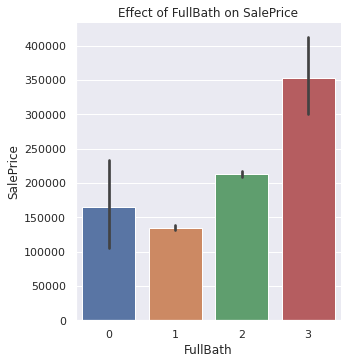

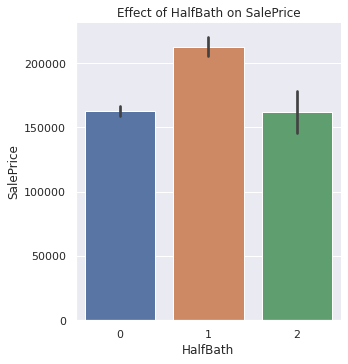

In [75]:
catplot('FullBath', train)
catplot('HalfBath', train)

Summarizing *FullBath* and *HalfBath* into a feature *Bath* could yield better results.

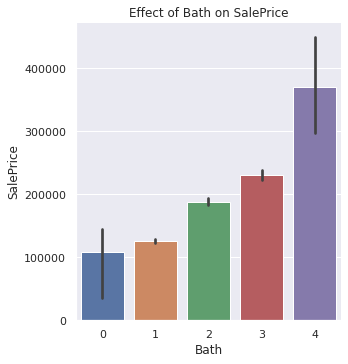

In [76]:
for dataset in (train, test, df):
    dataset['Bath'] = dataset['FullBath'] + dataset['HalfBath']

catplot('Bath', train)

**2.2.3 Feature *YearRemodAdd***

*YearBuilt* is highly correlated with *YearRemodAdd*. There is a clear positive effect on *SalePrice*. The feature *YearRemodAdd* may be biased due to the fact that it is same as *YearBuilt* if there was no remodeling or addition. Therefore, only *YearBuilt* will be used.

In [77]:
df.loc[:, ('YearBuilt', 'YearRemodAdd')].corr()

,YearBuilt,YearRemodAdd
YearBuilt,1.000000,0.611874
YearRemodAdd,0.611874,1.000000


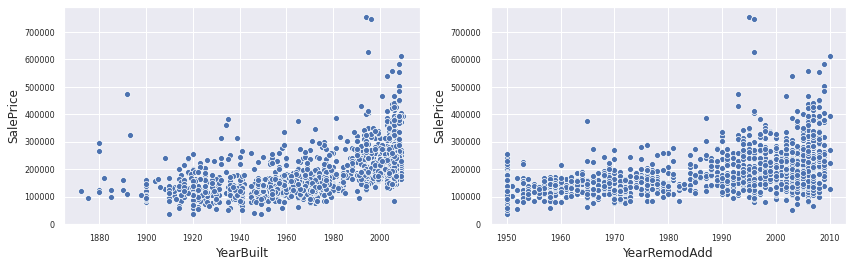

In [78]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train, ax=ax[0])
sns.scatterplot(x='YearRemodAdd', y='SalePrice', data=train, ax=ax[1])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(fontsize=8), plt.yticks(fontsize=8)
fig.show()

In [79]:
train = train.drop(['YearRemodAdd'], axis=1)
test = test.drop(['YearRemodAdd'], axis=1)
df = df.drop(['YearRemodAdd'], axis=1)

## 2.3 One-hot encoding for categorical features

In [80]:
X = df.drop(['SalePrice'], axis=1)

print('Columns before one-hot encoding:', X.shape[1])
        
for column in X:
    if X[column].dtypes == 'object':
        one_hot_encoding = pd.get_dummies(X[column])
        one_hot_encoding.columns = column + '_' + one_hot_encoding.columns.astype('str')
        X = pd.concat([X, one_hot_encoding], ignore_index=False, axis=1, sort=False)
        X = X.drop(column, axis=1)

print('Columns after one-hot encoding:', X.shape[1])

Columns before one-hot encoding: 78
Columns after one-hot encoding: 305


## 2.4 Polynomial features for numerical features

Polynomial features can be powerful for identifying interaction effects in the data. Given two features *a* and *b*, the degree-3 polynomial features are *a*, *b*, *a^2*, *ab*, *b^2*, *a^3*, *a^2b*, *ab^2* and *b^3*. Care must be taken since high degree polynomials make the model prone to overfitting.

In addition, a large number of features can make models computationally expensive. Therefore, degree-3 polynomials have only been created for the 10 features that correlate most with the target value *SalePrice*.

In [81]:
highest_correlation_target = df.drop(['Id'], axis=1).corr().abs().unstack().sort_values(kind='quicksort', ascending=False)#.drop_duplicates(keep='first')
highest_correlation_target = highest_correlation_target.reset_index().rename(columns={0: 'Correlation'})
highest_correlation_target = highest_correlation_target[highest_correlation_target['level_0'].str.contains('SalePrice') |
                                                        highest_correlation_target['level_1'].str.contains('SalePrice')]
highest_correlation_target = highest_correlation_target[highest_correlation_target['Correlation'] < 1]
highest_correlation_target.drop_duplicates(subset='Correlation')[:10]

,level_0,level_1,Correlation
40,TotalSF,SalePrice,0.832877
46,SalePrice,OverallQual,0.795774
54,GrLivArea,SalePrice,0.734968
70,TotalBsmtSF,SalePrice,0.651153
74,GarageCars,SalePrice,0.641047
78,SalePrice,1stFlrSF,0.631530
80,SalePrice,GarageArea,0.629217
100,SalePrice,Bath,0.570083
106,SalePrice,FullBath,0.562165
118,SalePrice,TotRmsAbvGrd,0.537769


In [82]:
poly = PolynomialFeatures(degree=3)
polynomial = pd.DataFrame(poly.fit_transform(X.loc[:, ('TotalSF', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', '1stFlrSF', 'GarageArea', 'Bath', 'FullBath', 'TotRmsAbvGrd')]),
                          columns=poly.get_feature_names(X.loc[:, ('TotalSF', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', '1stFlrSF', 'GarageArea', 'Bath', 'FullBath','TotRmsAbvGrd')].columns))

X = pd.concat([X, polynomial.loc[:, 'TotalSF^2':'TotRmsAbvGrd^3']], ignore_index=False, axis=1, sort=False)

## 2.5 Feature scaling for numerical features

In [83]:
for column in X:
    if column != 'Id':
        X[column] = MinMaxScaler().fit_transform(X[[column]])

## 2.6 Prepare the datasets

**2.6.1 Estimators**

The column *Id* is not used for model training.

In [84]:
X_trainval = X.loc[X['Id'] < 1461]
X_trainval = X_trainval.drop(['Id'], axis=1)
X_trainval.name = 'X_trainval'

X_test = X.loc[X['Id'] >= 1461]  
X_test = X_test.drop(['Id'], axis=1)
X_test.name = 'X_test'

Split trainval set into training and validation set to be able to estimate the generalization performance.

In [85]:
X_training, X_validation = train_test_split(X_trainval, test_size=0.2, shuffle=False)
X_training.name = 'X_training'
X_validation.name = 'X_validation'

In [86]:
print('Datasets for estimating generalization performance:')
print('X_training: {}'.format(X_training.shape))
print('X_validation: {}\n'.format(X_validation.shape))

print('Datasets for predicting test set:')
print('X_trainval: {}'.format(X_trainval.shape))
print('X_test: {}'.format(X_test.shape))

Datasets for estimating generalization performance:
X_training: (1166, 579)
X_validation: (292, 579)

Datasets for predicting test set:
X_trainval: (1458, 579)
X_test: (1459, 579)


Overview of the final trainval set:

In [87]:
X_trainval[:5]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalSF,Bath,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Not available,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Not available,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Not available,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Not available,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Not available,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Not available,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_Sbrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,

### 2.6.2 Target value

Similar to the estimators, the array which captures the *SalePrice* is split into an array y_trainval and an array y_validation to be able to estimate the generalization performance.

In [88]:
y_trainval = np.ravel(train[['SalePrice']])
y_training = y_trainval[:len(X_training)]
y_validation = y_trainval[len(X_training):]

# 3. Model Selection: Comparison of generalization performance

Findings:
- XGBoost and Gradient boosting perform best in terms of RMSE.
- Polynomial features do not yield better results.

In [89]:
model_comparison = pd.DataFrame({'Model': [], 'RMSE': []})

xg_boost = xgboost.XGBRegressor(n_estimators=500, max_depth=3, learning_rate=0.1)
xg_boost.name ='XGBoost'
gradient_boosting = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, max_depth=3, alpha=0.9)
gradient_boosting.name = 'Gradient boosting'
random_forest = RandomForestRegressor(n_estimators=200, max_features=40, max_depth=40)
random_forest.name = 'Random forest'
lasso = LassoCV(alphas=None, n_alphas=50, cv=10)
lasso.name = 'LASSO'

for model in [xg_boost, gradient_boosting, random_forest, lasso]:
    # Train the model with polynomials
    model.fit(X_training, y_training)
    rmse_poly = round(mean_squared_error(np.log(y_validation), np.log(model.predict(X_validation))) ** (1/2), 5)

    model_results = pd.DataFrame({'Model': [model.name + ' (polynomials)'], 'RMSE': [rmse_poly]})
    model_comparison = model_comparison.append(model_results, ignore_index=True)

    # Train the model without polynomials
    X_training_no_poly = X_training.loc[:, :'SaleCondition_Partial']
    X_validation_no_poly = X_validation.loc[:, :'SaleCondition_Partial']

    model.fit(X_training_no_poly, y_training)

    rmse_no_poly = round(mean_squared_error(np.log(y_validation), np.log(model.predict(X_validation_no_poly))) ** (1/2), 5)

    model_results = pd.DataFrame({'Model': [model.name + ' (no polynomials)'], 'RMSE': [rmse_no_poly]})
    model_comparison = model_comparison.append(model_results, ignore_index=True)
    
model_comparison.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

,Model,RMSE
0,XGBoost (no polynomials),0.11119
1,XGBoost (polynomials),0.11226
2,Gradient boosting (no polynomials),0.11236
3,Gradient boosting (polynomials),0.11295
4,LASSO (no polynomials),0.12183
5,LASSO (polynomials),0.12199
6,Random forest (no polynomials),0.13098
7,Random forest (polynomials),0.15603


# 4. Model Diagnostics

The predictions of the better performing model for every algorithm are analyzed more in-depth:
- GXBoost (no polynomials)
- Gradient boosting (no polynomials)
- Random forest (no polynomials)
- LASSO (no polynomials)

The following diagnostics will be adressed:
- Feature importance (10 most important features)
- Learning curve
- True vs. predicted *SalePrice*

Learning curves are a powerful technique to get insights into the generalization performance of the model. They show whether the algorithm suffers from overfitting and whether more training data is expected to improve the performance of the algorithm.

**Define functions:**

In [90]:
def learning(model):
    train_sizes, train_scores, test_scores = learning_curve(model, X_trainval, y_trainval, cv=5)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.style.use('seaborn-darkgrid')
    plt.plot(train_sizes, train_mean, color='#1f77b4', label='Training set', linewidth=2)  # Draw lines train
    plt.plot(train_sizes, test_mean, color='#d62728', label='Validation set', linewidth=2)  # Draw lines validation
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='#1f77b4', alpha=0.25)  # Draw band train
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='#d62728', alpha=0.25)  # Draw band validation
    plt.title('Learning curve {}'.format(model.name)), plt.xlabel('Training set size'), plt.ylabel('Score'), plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.show()

## 4.1 XGBoost

**4.1.1 Feature importance**

In [91]:
X_training_no_poly = X_training.loc[:, :'SaleCondition_Partial']
X_validation_no_poly = X_validation.loc[:, :'SaleCondition_Partial']

xg_boost.fit(X_training_no_poly, y_training)

feature_importance = pd.DataFrame({'Feature': X_training_no_poly.columns, 'Relative Importance': xg_boost.feature_importances_})
feature_importance = feature_importance.iloc[feature_importance['Relative Importance'].abs().argsort()[::-1]].reset_index(drop=True)
feature_importance[:10]

,Feature,Relative Importance
0,OverallQual,0.160025
1,TotalSF,0.128561
2,MSZoning_RL,0.080557
3,GarageCars,0.069923
4,KitchenAbvGr,0.052202
5,MSZoning_RM,0.049549
6,KitchenQual_Ex,0.047161
7,BsmtQual_Ex,0.043133
8,CentralAir_N,0.037997
9,KitchenQual_TA,0.027172


**4.1.2 Learning curve**

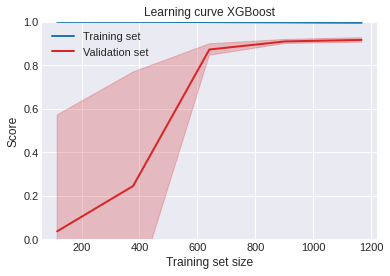

In [92]:
learning(xg_boost)

## 4.2 Gradient boosting

**4.2.1 Feature importance**

In [93]:
gradient_boosting.fit(X_training_no_poly, y_training)

feature_importance = pd.DataFrame({'Feature': X_training_no_poly.columns, 'Relative Importance': gradient_boosting.feature_importances_})
feature_importance = feature_importance.iloc[feature_importance['Relative Importance'].abs().argsort()[::-1]].reset_index(drop=True)
feature_importance[:10]

,Feature,Relative Importance
0,TotalSF,0.450991
1,OverallQual,0.305517
2,YearBuilt,0.026848
3,GarageCars,0.025647
4,GrLivArea,0.023858
5,BsmtFinSF1,0.021592
6,BsmtQual_Ex,0.017041
7,LotArea,0.012935
8,OverallCond,0.008318
9,Bath,0.006566


**4.2.2 Learning curve**

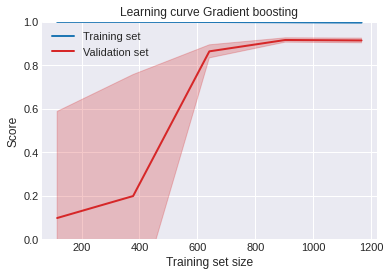

In [94]:
learning(gradient_boosting)

## 4.3 Random forest

**4.3.1 Feature importance**

In [95]:
random_forest.fit(X_training_no_poly, y_training)

feature_importance = pd.DataFrame({'Feature': X_training_no_poly.columns, 'Relative Importance': random_forest.feature_importances_})
feature_importance = feature_importance.iloc[feature_importance['Relative Importance'].abs().argsort()[::-1]].reset_index(drop=True)
feature_importance[:10]

,Feature,Relative Importance
0,TotalSF,0.166467
1,OverallQual,0.122322
2,GrLivArea,0.082905
3,GarageCars,0.060243
4,ExterQual_TA,0.045356
5,TotalBsmtSF,0.042836
6,GarageArea,0.041532
7,YearBuilt,0.038059
8,1stFlrSF,0.034106
9,GarageYrBlt,0.023263


**4.3.2 Learning curve**

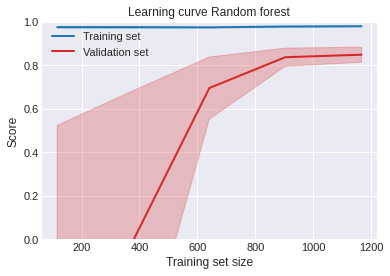

In [96]:
learning(random_forest)

## 4.4 LASSO

**4.4.1 Feature importance (highest coefficients)**

In [97]:
lasso.fit(X_training_no_poly, y_training)

alphas = pd.DataFrame(list(lasso.alphas_), columns=['Alpha'])
coefficient_path = lasso.path(X_training_no_poly, y_training, alphas=alphas)
coefficients = pd.DataFrame(coefficient_path[1], index=X_training_no_poly.columns).T.iloc[::-1].reset_index(drop=True)
result = pd.concat([alphas, coefficients], axis=1, sort=False)
best_alpha = result[result['Alpha'] == lasso.alpha_].tail(1)

used_features = best_alpha.columns[(best_alpha != 0).iloc[0]].tolist()
used_features.remove('Alpha')

best_coefficients = best_alpha[best_alpha['Alpha'] == lasso.alpha_].reset_index(drop=True)
best_coefficients = best_coefficients.drop(['Alpha'], axis=1)
best_coefficients = best_coefficients.iloc[0]
best_coefficients = pd.DataFrame({'Feature': best_coefficients.index, 'Coefficient': best_coefficients.values},
                                columns=['Feature', 'Coefficient'])

best_coefficients = best_coefficients.iloc[(-best_coefficients['Coefficient'].abs()).argsort()].reset_index(drop=True)

print('At the best alpha {0}, LASSO set {1} of the total {2} features equal to zero.'.format(
    round(lasso.alpha_, 5),  sum(best_coefficients['Coefficient'] == 0), len(best_coefficients['Coefficient'])))

best_coefficients[:10]

At the best alpha 53.09294, LASSO set 180 of the total 304 features equal to zero.


,Feature,Coefficient
0,GrLivArea,178740.196316
1,TotalSF,158215.683019
2,LotArea,72220.302483
3,OverallQual,62439.440444
4,BsmtFinSF1,61907.207994
5,RoofMatl_WdShngl,51139.567780
6,Neighborhood_StoneBr,42120.998420
7,OverallCond,38532.031948
8,KitchenAbvGr,-35516.001938
9,Neighborhood_NoRidge,34948.774927


**4.4.2 Learning curve**

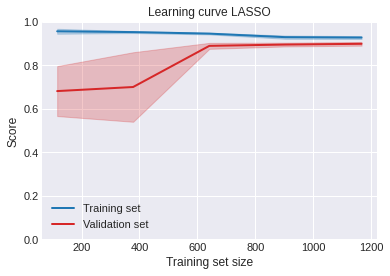

In [98]:
learning(lasso)

## 4.5 True vs. predicted *SalePice*

The predictions of the algorithms are plotted below to get more insights into how robust the models are. For better visibility, the first plot displays only the least expensive houses and the second plot the most expensive houses. 

**4.5.1 Lowest *SalePrice***

Findings:
- XGBoost and Gradient boosting are very robust to outliers.
- LASSO overestimates and Random forest underestimates the *SalePrice*.
- Random forest performs best for houses with a *SalePrice* between 60K and 100K.

In [99]:
prediction_validation_xg_boost = pd.DataFrame({'Id': X['Id'][:len(X_validation_no_poly)], 'Actual': y_validation, 'SalePrice': xg_boost.predict(X_validation_no_poly)})
prediction_validation_gradient_boosting = pd.DataFrame({'Id': X['Id'][:len(X_validation_no_poly)], 'Actual': y_validation, 'SalePrice': gradient_boosting.predict(X_validation_no_poly)})
prediction_validation_random_forest = pd.DataFrame({'Id': X['Id'][:len(X_validation_no_poly)], 'Actual': y_validation, 'SalePrice': random_forest.predict(X_validation_no_poly)})
prediction_validation_lasso = pd.DataFrame({'Id': X['Id'][:len(X_validation_no_poly)], 'Actual': y_validation, 'SalePrice': lasso.predict(X_validation_no_poly)})

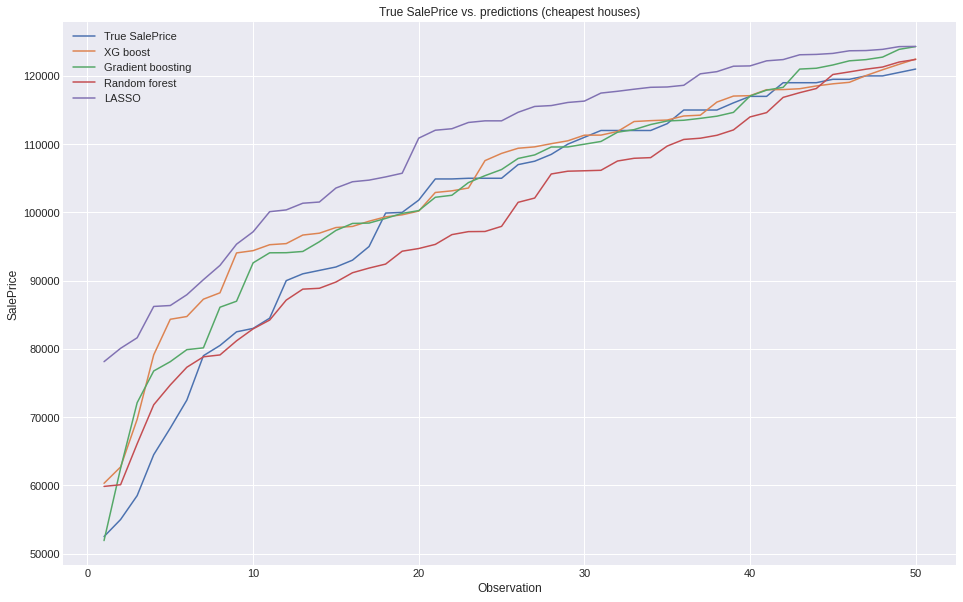

In [100]:
plt.figure(figsize=(16,10))
plt.plot(prediction_validation_gradient_boosting['Id'][:50], prediction_validation_gradient_boosting['Actual'].sort_values()[:50])
plt.plot(prediction_validation_gradient_boosting['Id'][:50], prediction_validation_gradient_boosting['SalePrice'].sort_values()[:50])
plt.plot(prediction_validation_xg_boost['Id'][:50], prediction_validation_xg_boost['SalePrice'].sort_values()[:50])
plt.plot(prediction_validation_lasso['Id'][:50], prediction_validation_lasso['SalePrice'].sort_values()[:50])
plt.plot(prediction_validation_random_forest['Id'][:50], prediction_validation_random_forest['SalePrice'].sort_values()[:50])
plt.legend(['True SalePrice', 'XG boost', 'Gradient boosting', 'Random forest', 'LASSO']), plt.ylabel('SalePrice'), plt.xlabel('Observation')
plt.title('True SalePrice vs. predictions (cheapest houses)')
plt.show()

**4.5.2 Houses with highest *SalePrice***

Finding:
- Gradient Boosting and XGBoost seem to be very robust to outliers.

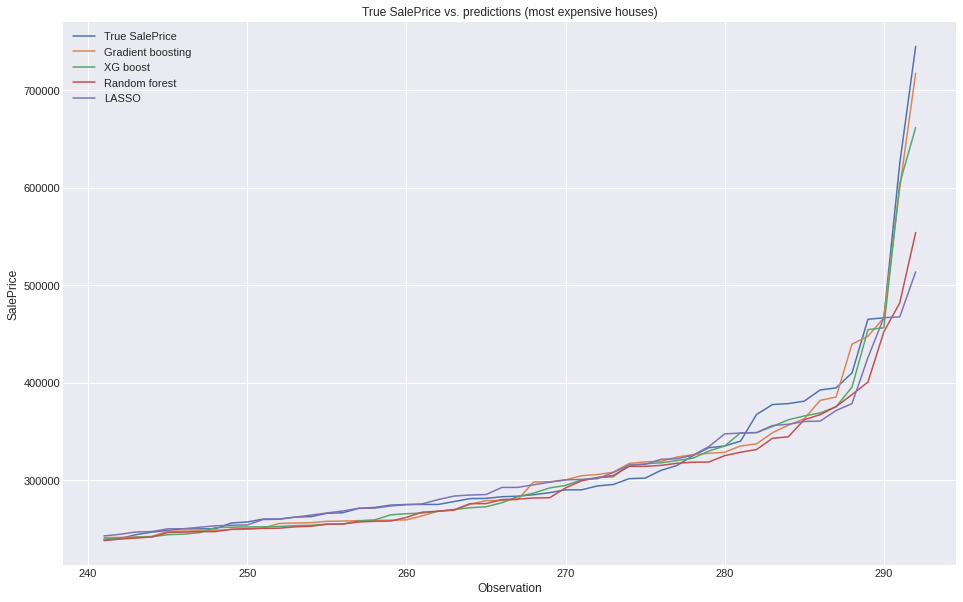

In [101]:
plt.figure(figsize=(16,10))
plt.plot(prediction_validation_gradient_boosting['Id'][240:], prediction_validation_gradient_boosting['Actual'].sort_values()[240:])
plt.plot(prediction_validation_gradient_boosting['Id'][240:], prediction_validation_gradient_boosting['SalePrice'].sort_values()[240:])
plt.plot(prediction_validation_xg_boost['Id'][240:], prediction_validation_xg_boost['SalePrice'].sort_values()[240:])
plt.plot(prediction_validation_random_forest['Id'][240:], prediction_validation_random_forest['SalePrice'].sort_values()[240:])
plt.plot(prediction_validation_lasso['Id'][240:], prediction_validation_lasso['SalePrice'].sort_values()[240:])
plt.legend(['True SalePrice', 'Gradient boosting', 'XG boost', 'Random forest', 'LASSO']), plt.ylabel('SalePrice'), plt.xlabel('Observation')
plt.title('True SalePrice vs. predictions (most expensive houses)')
plt.show()

With these insights, the average predictions of the algorithms were calculated. Thereby, the RMSE in the validation set was further reduced.

In [102]:
prediction_validation_average = ((gradient_boosting.predict(X_validation_no_poly) +
                                  xg_boost.predict(X_validation_no_poly) +
                                  random_forest.predict(X_validation_no_poly) +
                                  lasso.predict(X_validation_no_poly)) / 4)

rmse_average = round(mean_squared_error(np.log(y_validation), (np.log(prediction_validation_average))) ** (1/2), 5)
print('XGBoost, Gradient Boosting, Random Forest & LASSO:')
print('RMSE =', rmse_average)

XGBoost, Gradient Boosting, Random Forest & LASSO:
RMSE = 0.10785


In light of the finding that XGBoost and Gradient boosting predict outliers most accurately, houses with a predicted prices greater than 400K were predicted again only using XGBoost and Gradient boosting. The RMSE further decreased due to this.

- Indeed, XGBoost and gradient boosting make higher predictions for the outliers and the RMSE decreases.

In [103]:
xg_boost.fit(X_training_no_poly, y_training)
gradient_boosting.fit(X_training_no_poly, y_training)
random_forest.fit(X_training_no_poly, y_training)
lasso.fit(X_training_no_poly, y_training)

# Index has to be reset to match indices of X_validation_no_poly and prediction_validation_average (since observations have been dropped earlier)
X_validation_no_poly.set_index([list(range(len(X_training)+1, len(X_training)+1+len(X_validation_no_poly)))], inplace=True)

for index, value in enumerate(prediction_validation_average):
    if value > 400000:
        print('Index:', index)
        print(value)
        prediction_validation_average[index] = (gradient_boosting.predict(X_validation_no_poly.loc[[index+1167], :]) +
                                                xg_boost.predict(X_validation_no_poly.loc[[index+1167], :])) / 2
        print(prediction_validation_average[index])

Index: 2
538182.0499581115
601179.33397887
Index: 15
611771.958174295
690602.281912052
Index: 76
432033.9303215302
451743.58025667514
Index: 205
460593.0919477214
461460.7979520601


In [104]:
rmse_average = round(mean_squared_error(np.log(y_validation), (np.log(prediction_validation_average))) ** (1/2), 5)
print('Outliers only XGBoost, Gradient Boosting, Random Forest & LASSO:')
print('RMSE =', rmse_average)

Outliers only XGBoost, Gradient Boosting, Random Forest & LASSO:
RMSE = 0.10691


**Make test set predictions:**

In [105]:
X_trainval_no_poly = X_trainval.loc[:, :'SaleCondition_Partial']
X_test = X_test.loc[:, :'SaleCondition_Partial']

xg_boost.fit(X_trainval_no_poly, y_trainval)
gradient_boosting.fit(X_trainval_no_poly, y_trainval)
random_forest.fit(X_trainval_no_poly, y_trainval)
lasso.fit(X_trainval_no_poly, y_trainval)

prediction_test = pd.DataFrame({'Id': test['Id'], 'SalePrice': ((xg_boost.predict(X_test) +
                                                                 gradient_boosting.predict(X_test) +
                                                                 random_forest.predict(X_test) +
                                                                 lasso.predict(X_test)) / 4)})

# Make XGBoost and gradient boosting predict houses with predicted SalePrice >400K
for index, column in prediction_test.iterrows():
    if column['SalePrice'] > 400000:
        print('Index:', index)
        print(column['SalePrice'])
        prediction_test.loc[index, 'SalePrice'] = ((xg_boost.predict(X_test.loc[[1460+index], :]) + 
                                                   gradient_boosting.predict(X_test.loc[[1460+index], :]))/2)
        print(prediction_test.loc[index, 'SalePrice'])

Index: 19
516392.49660450674
562858.3099763708
Index: 200
468205.72816331143
497417.0584286824
Index: 203
515867.0542036687
551787.7497124142
Index: 211
468929.5339073857
507868.37808462325
Index: 217
513033.2103345606
558656.9306081848
Index: 245
496191.8760112386
534149.9213805257
Index: 460
424216.6699107837
443050.5891427408
Index: 507
450959.21939798305
480422.560195712
Index: 509
459104.2309950256
494358.2414985179
Index: 510
463191.4020839549
493147.72608259355
Index: 514
518545.90587280696
547468.7818646797
Index: 701
407021.6700966845
428211.44642364926
Index: 803
443681.91462468
456113.934830233
Index: 829
457236.2342099104
478257.7772611929
Index: 831
417445.6808385169
421954.4659029812
Index: 832
489531.8722601965
514288.40444763936
Index: 833
432941.2587532713
467798.8482816302
Index: 834
462936.30372586293
477770.85559190705
Index: 871
424218.46524375083
462188.7373832757
Index: 879
403127.0955622243
414065.79735978344
Index: 1089
656673.3598912853
689969.4643985699
Index

In [106]:
prediction_test.to_csv('my_submission.csv', index=False)